In [435]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime, calendar
import scipy.stats as stats
import statsmodels.api as sm
import re
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [478]:
train_data = pd.read_csv('train.csv')
train_data.index = pd.to_datetime(train_data['일자'])
#lunch_menu = train_data['중식메뉴']
del train_data['조식메뉴'], train_data['일자']


cases = pd.read_csv('일일코로나확진자.csv')
cases = cases[(cases['Entity'] == 'South Korea')].iloc[:, [2, 3]].reset_index(drop=True)
cases.index = pd.to_datetime(cases['Day'])
del cases['Day']
cases.columns = ['확진자수']
cases = cases[cases.index < '2021-04-10']
cases['확진자수'] = np.where(cases['확진자수'] == 0., 0., 1 / (1 + np.exp(- 1 / 100 * cases['확진자수'] + 3)))
cases = cases.rolling(7).mean().fillna(0)
cases.columns = ['Covid19']

temp = pd.read_csv('진주시_기온정보.csv', encoding='euc-kr')
temp.index = pd.to_datetime(temp['날짜'])
del temp['날짜'], temp['지점'], temp['최저기온(℃)']

rain = pd.read_csv('TimeRain.csv')
rain.index = pd.to_datetime(rain['날짜'])
del rain['날짜'], rain['강수량']


train_data = pd.concat([train_data, temp, cases, rain], axis=1)
train_data = train_data[~train_data['본사정원수'].isnull()].fillna(0.)
train_data.head()

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,평균기온(℃),최고기온(℃),Covid19,점심강수량,저녁강수량
2016-02-01,월,2601.0,50.0,150.0,238.0,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,-0.6,5.0,0.0,0.0,0.0
2016-02-02,화,2601.0,50.0,173.0,319.0,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,-2.3,6.2,0.0,0.0,0.0
2016-02-03,수,2601.0,56.0,180.0,111.0,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,-1.7,7.7,0.0,0.0,0.0
2016-02-04,목,2601.0,104.0,220.0,355.0,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,-0.2,7.7,0.0,0.0,0.0
2016-02-05,금,2601.0,278.0,181.0,34.0,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,1.3,9.6,0.0,0.0,0.0


In [479]:
def week_of_month(dt):

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return str(int(np.ceil(adjusted_dom/7.0)))


def MunhwaDay(row):
    if len(row['석식메뉴']) < 20 or row['석식계'] == 0:
        return 1
    else:
        return 0

def CleanMenuList(row):
    if row['석식계'] == 0:
        return ''
    else:
        return row['석식메뉴']
        
    
def GetMenuList(row):
    row = row.split()
    result = []
    for food in row:
        if '(' in food and ')' in food and ':' in food:
            continue
        
        if '*' in food:
            result.extend(food.split('*'))
            continue
        
        food = re.sub('\(New\)', '', food)
        #food = re.sub('/\w+', '', food)
        
        result.append(food)
    return result

    
train_data['개월'] = [f'{date.month}월' for date in train_data.index]
train_data['주차'] = [f'{week_of_month(date)}주차' for date in train_data.index]
train_data['문화day'] = train_data.apply(lambda row : MunhwaDay(row), axis=1)
train_data['석식메뉴'] = train_data.apply(lambda row : CleanMenuList(row), axis=1)

test_data = pd.read_csv('test.csv')
test_data.index = pd.to_datetime(test_data['일자'])
del test_data['조식메뉴'], test_data['일자']
test_data = pd.concat([test_data, temp, cases, rain], axis=1)
test_data = test_data[~test_data['본사정원수'].isnull()].fillna(0.)
test_data['개월'] = [f'{date.month}월' for date in test_data.index]
test_data['주차'] = [f'{week_of_month(date)}주차' for date in test_data.index]
test_data['문화day'] = [0 for i in range(len(test_data))]
whole_df = pd.concat([train_data, test_data], axis=0)

In [480]:
def TempClass(row):
    if row >= 30:
        return 'temp30+'
    elif row >= 25:
        return 'temp25+'
    elif row >= 20:
        return 'temp20+'
    elif row >= 15:
        return 'temp15+'
    elif row >= 10:
        return 'temp10+'
    elif row >= 5:
        return 'temp5+'
    elif row >= 0:
        return 'temp0+'
    elif row >= -5:
        return 'temp-5+'
    elif row >= -10:
        return 'temp-10+'
    elif row >= -15:
        return 'temp-15+'
    elif row >= -20:
        return 'temp-20+'
    else:
        return 'temp-20-'
    

    
def PreHolyday(row, pre_hol):
    if row in pre_hol.values:
        return 1
    else:
        return 0
    
def Temp30Class(row):
    if row >= 30:
        return 1
    else:
        return 0


In [481]:
whole_df['본사출근자수'] = whole_df['본사정원수'] - whole_df['본사휴가자수'] - whole_df['현본사소속재택근무자수']
whole_df['중식 참여율'] = whole_df['중식계'] / whole_df['본사출근자수']
whole_df['석식 참여율'] = whole_df['석식계'] / whole_df['본사출근자수']
whole_df['시간외근무율'] = whole_df['본사시간외근무명령서승인건수'] / whole_df['본사출근자수']
whole_df['평균기온'] = whole_df['평균기온(℃)'].apply(TempClass)
whole_df['최고기온30+'] = whole_df['최고기온(℃)'].apply(Temp30Class)
whole_df['중식메뉴'] = whole_df['중식메뉴'].apply(GetMenuList)
whole_df['석식메뉴'] = whole_df['석식메뉴'].apply(GetMenuList)

del whole_df['본사정원수'], whole_df['본사휴가자수'], whole_df['현본사소속재택근무자수']
del whole_df['중식계'], whole_df['석식계'], whole_df['본사시간외근무명령서승인건수']
del whole_df['평균기온(℃)'], whole_df['최고기온(℃)']
    
pre_hol = pd.read_csv('pre_holiday.txt', encoding='utf8')
pre_hol = pd.to_datetime(pre_hol['공휴일전평일'])
whole_df['pre공휴일'] = [PreHolyday(date, pre_hol) for date in whole_df.index]

In [482]:
menu = whole_df[['중식메뉴', '석식메뉴']]
del whole_df['중식메뉴'], whole_df['석식메뉴']

In [483]:
#def MenuEncoding(row, menu_list1, menu_list2):
#    result = []
#    for food in row:
#        try:
#            result.append(menu_list1[food])
#        except:
#            continue
#    for food in row:
#        try:
#            result.append(menu_list2[food])
#        except:
#            continue
#    
#    
#    return result
#
#def MakeDTM(row):
#    if len(row) == 0:
#        return pd.Series(0, index=range(98))
#    res = np.where(encoder.transform(np.array(row).reshape(-1,1)).toarray().sum(axis=0) >= 1, 1., 0.)
#    return pd.Series(res)
#
#menu_label = pd.read_csv('menu_label.csv').fillna('없음')
#menu_list1 = {}
#for _, row in menu_label[['menu', 'label1']].iterrows():
#    menu_list1[row['menu']] = row['label1']
#    
#menu_list2 = {}
#for _, row in menu_label[['menu', 'label2']].iterrows():
#    menu_list2[row['menu']] = row['label2']
#    
#menu['중식인코딩'] = menu['중식메뉴'].apply(lambda row : MenuEncoding(row, menu_list1, menu_list2))
#menu['석식인코딩'] = menu['석식메뉴'].apply(lambda row : MenuEncoding(row, menu_list1, menu_list2))
#
#encoder = OneHotEncoder()
#menu_list = menu_label['label1'].unique().tolist()
#menu_list.extend(menu_label['label2'].unique().tolist())
#menu_list.remove('없음')
#menu_list[0:0] = ['없음']
#menu_list = [[food] for food in menu_list]
#encoder.fit(menu_list)
#
#lunch_menu = menu['중식인코딩'].apply(MakeDTM)
#dinner_menu = menu['석식인코딩'].apply(MakeDTM)

In [486]:

day_dummy = pd.get_dummies(whole_df['요일'])
month_dummy = pd.get_dummies(whole_df['개월'])
week_dummy = pd.get_dummies(whole_df['주차'])
avgtemp_dummy = pd.get_dummies(whole_df[['평균기온']])

whole_df = pd.concat([whole_df, day_dummy, month_dummy, week_dummy,
                      avgtemp_dummy], axis=1)
drop_cols = ['요일', '개월', '주차', '평균기온']
whole_df.drop(drop_cols, axis=1, inplace=True)
whole_df = sm.add_constant(whole_df)
train_y_lunch = whole_df['중식 참여율'].dropna()
train_y_dinner = whole_df['석식 참여율'].dropna()
del whole_df['중식 참여율'], whole_df['석식 참여율']
whole_df['4주x금요일'] = whole_df['4주차'] * whole_df['금']



In [495]:
train_x, test_x = copy.deepcopy(whole_df.iloc[:len(train_data),:]), copy.deepcopy(whole_df.iloc[len(train_data):,:])
train_x.drop(datetime.datetime(2018,6,22), axis=0, inplace=True)
train_y_lunch.drop(datetime.datetime(2018,6,22), axis=0, inplace=True)
train_y_dinner.drop(datetime.datetime(2018,6,22), axis=0, inplace=True)

to_min = train_x['본사출근자수'].min()
to_max = train_x['본사출근자수'].max()

train_x['본사출근자수'] = (train_x['본사출근자수'] - to_min) / (to_max - to_min)
test_x['본사출근자수'] = (test_x['본사출근자수'] - to_min) / (to_max - to_min)

out_min = train_x['본사출장자수'].min()
out_max = train_x['본사출장자수'].max()

train_x['본사출장자수'] = (train_x['본사출장자수'] - out_min) / (out_max - out_min)
test_x['본사출장자수'] = (test_x['본사출장자수'] - out_min) / (out_max - out_min)


In [496]:
train_x_lunch, train_x_dinner = copy.deepcopy(train_x), copy.deepcopy(train_x)
del train_x_lunch['저녁강수량'], train_x_dinner['점심강수량']
test_x_lunch, test_x_dinner = copy.deepcopy(test_x), copy.deepcopy(test_x)
del test_x_lunch['저녁강수량'], test_x_dinner['점심강수량']

In [497]:
train_x_lunch = pd.concat([train_x_lunch, lunch_menu], axis=1).dropna()
test_x_lunch = pd.concat([test_x_lunch, lunch_menu], axis=1).dropna()
train_x_dinner = pd.concat([train_x_dinner, dinner_menu], axis=1).dropna()
test_x_dinner = pd.concat([test_x_dinner, dinner_menu], axis=1).dropna()

In [60]:
res1 = sm.OLS(train_y_lunch, train_x_lunch, missing='drop').fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 중식 참여율   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     78.49
Date:                Thu, 01 Jul 2021   Prob (F-statistic):          1.45e-286
Time:                        18:28:36   Log-Likelihood:                 2073.9
No. Observations:                1205   AIC:                            -4072.
Df Residuals:                    1167   BIC:                            -3878.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3175      0.007     42.549      0.000       0.303       0.332
본사출장자수           -0.1182      0.018     -6.613      0.000      -0.153      -0.083
Covid19           0.0289      0.008      3.600      0.000       0.013       0.045
점심강수량             0.0015      0.000      3.578      0.000       0.001       0.002
문화day             0.0013      0.008      0.164      0.870      -0.014       0.016
본사출근자수           -0.1639      0.016    -10.065      0.000      -0.196      -0.132
시간외근무율            0.2503      0.030      8.412      0.000       0.192       0.309
최고기온30+          -0.0040      0.006     -0.677      0.499      -0.016       0.008
pre공휴일           -0.0560      0.007     -7.670      0.000      -0.070      -0.042
금                 0.0092      0.005      2.033      0.042       0.000       0.018
목                 0.0309      0.004      8.524      0.000       0.024       0.038
수                 0.0923      0.004     21.580      0.000       0.084       0.101
월                 0.1285      0.004     32.744      0.000       0.121       0.136
화                 0.0566      0.004     15.033      0.000       0.049       0.064
10월               0.0438      0.005      8.216      0.000       0.033       0.054
11월               0.0150      0.006      2.630      0.009       0.004       0.026
12월              -0.0101      0.007     -1.501      0.134      -0.023       0.003
1월                0.0209      0.007      2.885      0.004       0.007       0.035
2월                0.0527      0.007      7.894      0.000       0.040       0.066
3월                0.0410      0.006      7.275      0.000       0.030       0.052
4월                0.0296      0.005      5.641      0.000       0.019       0.040
5월                0.0307      0.006      5.365      0.000       0.019       0.042
6월                0.0259      0.007      3.865      0.000       0.013       0.039
7월                0.0163      0.007      2.302      0.022       0.002       0.030
8월                0.0214      0.008      2.705      0.007       0.006       0.037
9월                0.0303      0.006      4.822      0.000       0.018       0.043
1주차               0.0640      0.004     14.484      0.000       0.055       0.073
2주차               0.0618      0.003     18.280      0.000       0.055       0.068
3주차               0.0607      0.003     17.610      0.000       0.054       0.067
4주차               0.0593      0.004     15.994      0.000       0.052       0.067
5주차               0.0531      0.004     14.842      0.000       0.046       0.060
6주차               0.0185      0.009      2.013      0.044       0.000       0.037
평균기온_temp-10+     0.0461      0.015      3.126      0.002       0.017       0.075
평균기온_temp-5+      0.0402      0.008      5.328      0.000       0.025       0.055
평균기온_temp0+       0.0390      0.006      6.158   

In [61]:
res2 = sm.OLS(train_y_dinner, train_x_dinner, missing='drop').fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 석식 참여율   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     70.52
Date:                Thu, 01 Jul 2021   Prob (F-statistic):          9.14e-268
Time:                        18:28:37   Log-Likelihood:                 2527.3
No. Observations:                1205   AIC:                            -4979.
Df Residuals:                    1167   BIC:                            -4785.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1477      0.005     28.822      0.000       0.138       0.158
본사출장자수           -0.0214      0.012     -1.743      0.082      -0.045       0.003
Covid19          -0.0340      0.006     -6.179      0.000      -0.045      -0.023
저녁강수량             0.0002      0.000      0.412      0.680      -0.001       0.001
문화day            -0.1555      0.005    -29.253      0.000      -0.166      -0.145
본사출근자수           -0.0929      0.011     -8.318      0.000      -0.115      -0.071
시간외근무율            0.3168      0.020     15.500      0.000       0.277       0.357
최고기온30+           0.0046      0.004      1.143      0.253      -0.003       0.013
pre공휴일           -0.0374      0.005     -7.480      0.000      -0.047      -0.028
금                 0.0346      0.003     11.140      0.000       0.028       0.041
목                 0.0184      0.002      7.389      0.000       0.013       0.023
수                 0.0448      0.003     15.220      0.000       0.039       0.051
월                 0.0252      0.003      9.341      0.000       0.020       0.030
화                 0.0248      0.003      9.607      0.000       0.020       0.030
10월               0.0223      0.004      6.086      0.000       0.015       0.029
11월               0.0079      0.004      2.009      0.045       0.000       0.016
12월              -0.0093      0.005     -2.029      0.043      -0.018      -0.000
1월                0.0023      0.005      0.463      0.644      -0.007       0.012
2월                0.0326      0.005      7.111      0.000       0.024       0.042
3월                0.0384      0.004      9.941      0.000       0.031       0.046
4월                0.0253      0.004      7.011      0.000       0.018       0.032
5월                0.0119      0.004      3.038      0.002       0.004       0.020
6월                0.0088      0.005      1.909      0.057      -0.000       0.018
7월               -0.0050      0.005     -1.043      0.297      -0.014       0.004
8월                0.0041      0.005      0.752      0.452      -0.007       0.015
9월                0.0087      0.004      2.011      0.045       0.000       0.017
1주차               0.0249      0.003      8.220      0.000       0.019       0.031
2주차               0.0246      0.002     10.584      0.000       0.020       0.029
3주차               0.0232      0.002      9.789      0.000       0.019       0.028
4주차               0.0213      0.003      8.391      0.000       0.016       0.026
5주차               0.0229      0.002      9.323      0.000       0.018       0.028
6주차               0.0308      0.006      4.873      0.000       0.018       0.043
평균기온_temp-10+     0.0096      0.010      0.947      0.344      -0.010       0.029
평균기온_temp-5+      0.0181      0.005      3.501      0.000       0.008       0.028
평균기온_temp0+       0.0148      0.004      3.420   

In [500]:
model_lunch = RandomForestRegressor(n_jobs=-1, random_state=42)
model_dinner = RandomForestRegressor(n_jobs=-1, random_state=42)
model_lunch.fit(train_x_lunch, train_y_lunch)
model_dinner.fit(train_x_dinner, train_y_dinner)

RandomForestRegressor(n_jobs=-1, random_state=42)

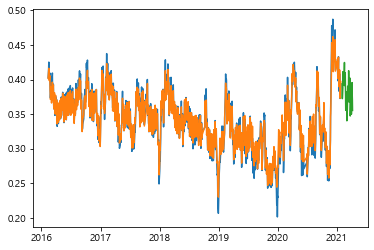

In [501]:
plt.plot(train_y_lunch.rolling(7).mean())
plt.plot(pd.Series(model_lunch.predict(train_x_lunch.iloc[:,:]).flatten(), index=train_y_lunch.index).rolling(7).mean())
plt.plot(pd.Series(model_lunch.predict(test_x_lunch.iloc[:,:]).flatten(), index=test_x_lunch.index).rolling(7).mean())

In [14]:
#sub = pd.read_csv('sample_submission.csv')
#sub['중식계'] = (model_lunch.predict(test_x) * whole_df['본사출근자수'][-50:]).values
#sub['석식계'] = (model_dinner.predict(test_x) * whole_df['본사출근자수'][-50:]).values
#sub.to_csv('submission_RForest_3.csv', index=False)

In [502]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

params = {
    'learning_rate': [0.0, 0.1, 0.09, 0.089, 0.08],
    'boosting_type': ['gbtree', 'gblinear', 'dart'],
    
}

lunch_r = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
dinner_r = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

lunch_model = GridSearchCV(lunch_r, params, scoring='neg_mean_absolute_error')
dinner_model = GridSearchCV(dinner_r, params, scoring='neg_mean_absolute_error')

In [503]:
lunch_model.fit(train_x_lunch.iloc[:,1:], train_y_lunch)
print(lunch_model.best_score_, lunch_model.best_params_)
lunch_model = lunch_model.best_estimator_

[22:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only u

[22:22:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:22:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only u

[22:23:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:23:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only u

[22:23:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:23:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:23:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only u

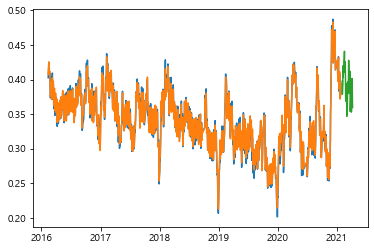

In [504]:
plt.plot(train_y_lunch.rolling(7).mean())
plt.plot(pd.Series(lunch_model.predict(train_x_lunch.iloc[:,1:]).flatten(), index=train_y_lunch.index).rolling(7).mean())
plt.plot(pd.Series(lunch_model.predict(test_x_lunch.iloc[:,1:]).flatten(), index=test_x.index).rolling(7).mean())

In [505]:
dinner_model.fit(train_x_dinner.iloc[:,1:], train_y_dinner)
print(dinner_model.best_score_, dinner_model.best_params_)
dinner_model = dinner_model.best_estimator_

#test_x = test[['월', '일', '요일(석식)', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
#y_pred = dinner_model.predict(test_x)

[22:23:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:23:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:23:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only u

[22:24:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:24:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:24:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only u

[22:24:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:24:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:24:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only u

[22:24:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:24:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:24:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only u

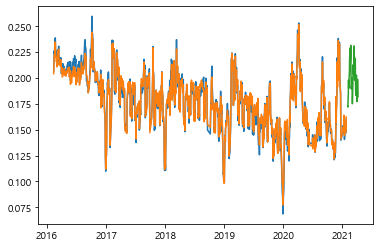

In [506]:
plt.plot(train_y_dinner.rolling(7).mean())
plt.plot(pd.Series(dinner_model.predict(train_x_dinner.iloc[:,1:]).flatten(), index=train_y_lunch.index).rolling(7).mean())
plt.plot(pd.Series(dinner_model.predict(test_x_dinner.iloc[:,1:]).flatten(), index=test_x.index).rolling(7).mean())

In [507]:
lunch_r.fit(train_x_lunch.iloc[:,1:], train_y_lunch)
dinner_r.fit(train_x_dinner.iloc[:,1:], train_y_dinner)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

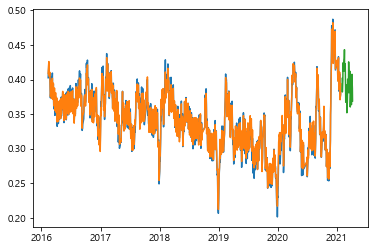

In [508]:
plt.plot(train_y_lunch.rolling(7).mean())
plt.plot(pd.Series(lunch_r.predict(train_x_lunch.iloc[:,1:]).flatten(), index=train_y_lunch.index).rolling(7).mean())
plt.plot(pd.Series(lunch_r.predict(test_x_lunch.iloc[:,1:]).flatten(), index=test_x.index).rolling(7).mean())

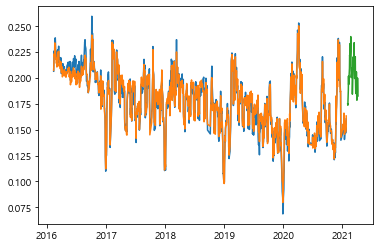

In [509]:
plt.plot(train_y_dinner.rolling(7).mean())
plt.plot(pd.Series(dinner_r.predict(train_x_dinner.iloc[:,1:]).flatten(), index=train_y_lunch.index).rolling(7).mean())
plt.plot(pd.Series(dinner_r.predict(test_x_dinner.iloc[:,1:]).flatten(), index=test_x.index).rolling(7).mean())

In [510]:
pred_lunch = 0.4 * model_lunch.predict(test_x_lunch) + 0.3 * lunch_model.predict(test_x_lunch.iloc[:,1:]) \
             + 0.3 * lunch_r.predict(test_x_lunch.iloc[:,1:]) 
pred_dinner = 0.4 * model_dinner.predict(test_x_dinner) + 0.3 * dinner_model.predict(test_x_dinner.iloc[:,1:]) \
             + 0.3 * dinner_r.predict(test_x_dinner.iloc[:,1:])

In [511]:
sub = pd.read_csv('sample_submission.csv')
sub['중식계'] = (pred_lunch * whole_df['본사출근자수'][-50:]).values.round()
sub['석식계'] = (pred_dinner * whole_df['본사출근자수'][-50:]).values.round()
sub.to_csv('submission_Ensemble_DTM.csv', index=False)

In [95]:
def HumidClass(row):
    if row >= 70:
        return 'Humid High'
    elif row >= 30:
        return 'Humid Middle'
    else:
        return 'Humid Low'
    
train_data = pd.read_csv('train.csv')
train_data.index = pd.to_datetime(train_data['일자'])
lunch_menu = train_data['중식메뉴']
del train_data['조식메뉴'], train_data['일자']


cases = pd.read_csv('일일코로나확진자.csv')
cases = cases[(cases['Entity'] == 'South Korea')].iloc[:, [2, 3]].reset_index(drop=True)
cases.index = pd.to_datetime(cases['Day'])
del cases['Day']
cases.columns = ['확진자수']
cases = cases[cases.index < '2021-04-10']
cases.columns = ['Covid19']

temp = pd.read_csv('진주시_기온정보.csv', encoding='euc-kr')
temp.index = pd.to_datetime(temp['날짜'])
del temp['날짜'], temp['지점'], temp['최저기온(℃)']

hum = pd.read_csv('진주시강수량.csv', encoding='euc-kr')
hum.index = pd.to_datetime(hum['날짜'])
del hum['날짜'], hum['지점']
hum.fillna(0, inplace=True)


train_data = pd.concat([train_data, temp, cases, hum], axis=1)
train_data = train_data[~train_data['본사정원수'].isnull()].fillna(0.)
train_data.head()
train_data['개월'] = [f'{date.month}월' for date in train_data.index]
train_data['주차'] = [f'{week_of_month(date)}주차' for date in train_data.index]
train_data['문화day'] = train_data.apply(lambda row : MunhwaDay(row), axis=1)

test_data = pd.read_csv('test.csv')
test_data.index = pd.to_datetime(test_data['일자'])
del test_data['조식메뉴'], test_data['중식메뉴'], test_data['석식메뉴'], test_data['일자']
test_data = pd.concat([test_data, temp, cases, hum], axis=1)
test_data = test_data[~test_data['본사정원수'].isnull()].fillna(0.)
test_data['개월'] = [f'{date.month}월' for date in test_data.index]
test_data['주차'] = [f'{week_of_month(date)}주차' for date in test_data.index]
test_data['문화day'] = [0 for i in range(len(test_data))]
whole_df = pd.concat([train_data, test_data], axis=0)

whole_df['본사출근자수'] = whole_df['본사정원수'] - whole_df['본사휴가자수'] - whole_df['본사출장자수'] - whole_df['현본사소속재택근무자수']
whole_df['중식 참여율'] = whole_df['중식계'] / whole_df['본사출근자수']
whole_df['석식 참여율'] = whole_df['석식계'] / whole_df['본사출근자수']
whole_df['시간외근무율'] = whole_df['본사시간외근무명령서승인건수'] / whole_df['본사출근자수']
whole_df['평균기온'] = whole_df['평균기온(℃)'].apply(TempClass)
whole_df['최고기온'] = whole_df['최고기온(℃)'].apply(Temp30Class)

del whole_df['본사정원수'], whole_df['본사휴가자수'], whole_df['본사출장자수'], whole_df['현본사소속재택근무자수']
del whole_df['중식계'], whole_df['석식계'], whole_df['본사시간외근무명령서승인건수']
del whole_df['평균기온(℃)'], whole_df['최고기온(℃)']
pre_hol = pd.read_csv('pre_holiday.txt', encoding='utf8')
pre_hol = pd.to_datetime(pre_hol['공휴일전평일'])
whole_df['pre공휴일'] = [PreHolyday(date, pre_hol) for date in whole_df.index]

del whole_df['중식메뉴'], whole_df['석식메뉴']
day_dummy = pd.get_dummies(whole_df['요일'])
month_dummy = pd.get_dummies(whole_df['개월'])
week_dummy = pd.get_dummies(whole_df['주차'])
avgtemp_dummy = pd.get_dummies(whole_df[['평균기온']])

whole_df = pd.concat([whole_df, day_dummy, month_dummy, week_dummy,
                      avgtemp_dummy], axis=1)
drop_cols = ['요일', '개월', '주차', '평균기온']
whole_df.drop(drop_cols, axis=1, inplace=True)
whole_df = sm.add_constant(whole_df)
train_y_lunch = whole_df['중식 참여율'].dropna()
train_y_dinner = whole_df['석식 참여율'].dropna()
del whole_df['중식 참여율'], whole_df['석식 참여율']
whole_df['4주x금요일'] = whole_df['4주차'] * whole_df['금']

train_x, test_x = copy.deepcopy(whole_df.iloc[:len(train_data),:]), copy.deepcopy(whole_df.iloc[len(train_data):,:])

to_min = train_x['본사출근자수'].min()
to_max = train_x['본사출근자수'].max()

train_x['본사출근자수'] = (train_x['본사출근자수'] - to_min) / (to_max - to_min)
test_x['본사출근자수'] = (test_x['본사출근자수'] - to_min) / (to_max - to_min)

In [104]:
model_lunch = RandomForestRegressor(n_jobs=-1, random_state=42)
model_dinner = RandomForestRegressor(n_jobs=-1, random_state=42)
model_lunch.fit(train_x, train_y_lunch)
model_dinner.fit(train_x, train_y_dinner)

params = {
    'learning_rate': [0.0, 0.1, 0.09, 0.089, 0.08],
    'boosting_type': ['gbtree', 'gblinear', 'dart'],
    
}

lunch_r = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
dinner_r = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

lunch_model = GridSearchCV(lunch_r, params, scoring='neg_mean_absolute_error')
dinner_model = GridSearchCV(dinner_r, params, scoring='neg_mean_absolute_error')


lunch_model.fit(train_x.iloc[:,1:], train_y_lunch)
print(lunch_model.best_score_, lunch_model.best_params_)
lunch_model = lunch_model.best_estimator_

dinner_model.fit(train_x.iloc[:,1:], train_y_dinner)
print(dinner_model.best_score_, dinner_model.best_params_)
dinner_model = dinner_model.best_estimator_

lunch_r.fit(train_x.iloc[:,1:], train_y_lunch)
dinner_r.fit(train_x.iloc[:,1:], train_y_dinner)

pred_lunch = 0.4 * model_lunch.predict(test_x) + 0.3 * lunch_model.predict(test_x.iloc[:,1:]) \
             + 0.3 * lunch_r.predict(test_x.iloc[:,1:]) 
pred_dinner = 0.4 * model_dinner.predict(test_x) + 0.3 * dinner_model.predict(test_x.iloc[:,1:]) \
             + 0.3 * dinner_r.predict(test_x.iloc[:,1:])

[18:57:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only u

[18:57:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only u

[18:58:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only u

[18:58:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only u

[18:58:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only u

[18:58:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only u

[18:59:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:59:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:59:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only u

[18:59:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:59:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:59:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type" } might not be used.

  This may not be accurate due to some parameters are only u

In [105]:
sub = pd.read_csv('sample_submission.csv')
sub['중식계'] = (pred_lunch * whole_df['본사출근자수'][-50:]).values.round()
sub['석식계'] = (pred_dinner * whole_df['본사출근자수'][-50:]).values.round()
sub.to_csv('submission_Ensemble_XGboost_GridS_RF_raw.csv', index=False)

In [106]:
sub

,일자,중식계,석식계
0,2021-01-27,1021.0,405.0
1,2021-01-28,969.0,415.0
2,2021-01-29,684.0,269.0
3,2021-02-01,1274.0,524.0
4,2021-02-02,1096.0,451.0
5,2021-02-03,1126.0,468.0
6,2021-02-04,1064.0,455.0
7,2021-02-05,841.0,349.0
8,2021-02-08,1288.0,671.0
9,2021-02-09,1026.0,479.0


In [417]:
def MenuEncoding(row, menu_list1, menu_list2):
    result = []
    for food in row:
        try:
            result.append(menu_list1[food])
        except:
            continue
    for food in row:
        try:
            result.append(menu_list2[food])
        except:
            continue
    
    
    return result

def MakeDTM(row):
    if len(row) == 0:
        return pd.Series(0, index=range(98))
    res = np.where(encoder.transform(np.array(row).reshape(-1,1)).toarray().sum(axis=0) >= 1, 1., 0.)
    return pd.Series(res)

menu_label = pd.read_csv('menu_label.csv').fillna('없음')
menu_list1 = {}
for _, row in menu_label[['menu', 'label1']].iterrows():
    menu_list1[row['menu']] = row['label1']
    
menu_list2 = {}
for _, row in menu_label[['menu', 'label2']].iterrows():
    menu_list2[row['menu']] = row['label2']
    
menu['중식인코딩'] = menu['중식메뉴'].apply(lambda row : MenuEncoding(row, menu_list1, menu_list2))
menu['석식인코딩'] = menu['석식메뉴'].apply(lambda row : MenuEncoding(row, menu_list1, menu_list2))

encoder = OneHotEncoder()
menu_list = menu_label['label1'].unique().tolist()
menu_list.extend(menu_label['label2'].unique().tolist())
menu_list.remove('없음')
menu_list[0:0] = ['없음']
menu_list = [[food] for food in menu_list]
encoder.fit(menu_list)

lunch_menu = menu['중식인코딩'].apply(MakeDTM)
dinner_menu = menu['석식인코딩'].apply(MakeDTM)

In [498]:
res1 = sm.OLS(train_y_lunch, train_x_lunch, missing='drop').fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 중식 참여율   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     26.54
Date:                Thu, 01 Jul 2021   Prob (F-statistic):          5.00e-249
Time:                        22:17:26   Log-Likelihood:                 2150.3
No. Observations:                1204   AIC:                            -4057.
Df Residuals:                    1082   BIC:                            -3435.
Df Model:                         121                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2868      0.022     12.946      0.000       0.243       0.330
본사출장자수           -0.1106      0.018     -6.171      0.000      -0.146      -0.075
Covid19           0.0548      0.010      5.610      0.000       0.036       0.074
점심강수량             0.0017      0.000      3.894      0.000       0.001       0.003
문화day            -0.0033      0.008     -0.400      0.689      -0.019       0.013
본사출근자수           -0.1644      0.016     -9.995      0.000      -0.197      -0.132
시간외근무율            0.2525      0.031      8.275      0.000       0.193       0.312
최고기온30+          -0.0035      0.006     -0.575      0.565      -0.015       0.008
pre공휴일           -0.0480      0.008     -6.352      0.000      -0.063      -0.033
금                 0.0018      0.006      0.293      0.770      -0.010       0.014
목                 0.0241      0.006      4.358      0.000       0.013       0.035
수                 0.0925      0.006     14.247      0.000       0.080       0.105
월                 0.1188      0.006     19.463      0.000       0.107       0.131
화                 0.0496      0.006      8.609      0.000       0.038       0.061
10월               0.0441      0.006      7.855      0.000       0.033       0.055
11월               0.0150      0.006      2.439      0.015       0.003       0.027
12월              -0.0102      0.007     -1.452      0.147      -0.024       0.004
1월                0.0193      0.008      2.553      0.011       0.004       0.034
2월                0.0497      0.007      6.878      0.000       0.035       0.064
3월                0.0355      0.006      5.957      0.000       0.024       0.047
4월                0.0242      0.005      4.398      0.000       0.013       0.035
5월                0.0266      0.006      4.511      0.000       0.015       0.038
6월                0.0209      0.007      2.958      0.003       0.007       0.035
7월                0.0133      0.007      1.805      0.071      -0.001       0.028
8월                0.0182      0.008      2.234      0.026       0.002       0.034
9월                0.0303      0.007      4.540      0.000       0.017       0.043
1주차               0.0583      0.006      9.950      0.000       0.047       0.070
2주차               0.0568      0.005     11.573      0.000       0.047       0.066
3주차               0.0556      0.005     11.340      0.000       0.046       0.065
4주차               0.0538      0.005     10.390      0.000       0.044       0.064
5주차               0.0487      0.005      9.813      0.000       0.039       0.058
6주차               0.0137      0.010      1.366      0.172      -0.006       0.033
평균기온_temp-10+     0.0445      0.015      2.988      0.003       0.015       0.074
평균기온_temp-5+      0.0347      0.008      4.376      0.000       0.019       0.050
평균기온_temp0+       0.0366      0.007      5.460   

In [499]:
res2 = sm.OLS(train_y_dinner, train_x_dinner, missing='drop').fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 석식 참여율   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     26.39
Date:                Thu, 01 Jul 2021   Prob (F-statistic):          3.44e-239
Time:                        22:20:41   Log-Likelihood:                 2602.4
No. Observations:                1204   AIC:                            -4981.
Df Residuals:                    1092   BIC:                            -4410.
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1435      0.006     22.732      0.000       0.131       0.156
본사출장자수           -0.0298      0.012     -2.409      0.016      -0.054      -0.006
Covid19          -0.0254      0.006     -4.133      0.000      -0.038      -0.013
저녁강수량           7.66e-05      0.000      0.206      0.837      -0.001       0.001
문화day            -0.1481      0.008    -18.572      0.000      -0.164      -0.132
본사출근자수           -0.0936      0.011     -8.381      0.000      -0.116      -0.072
시간외근무율            0.3136      0.021     15.190      0.000       0.273       0.354
최고기온30+           0.0027      0.004      0.659      0.510      -0.005       0.011
pre공휴일           -0.0361      0.005     -7.171      0.000      -0.046      -0.026
금                 0.0347      0.003      9.999      0.000       0.028       0.042
목                 0.0150      0.003      5.163      0.000       0.009       0.021
수                 0.0452      0.003     13.759      0.000       0.039       0.052
월                 0.0261      0.003      8.341      0.000       0.020       0.032
화                 0.0225      0.003      7.322      0.000       0.016       0.029
10월               0.0227      0.004      6.171      0.000       0.015       0.030
11월               0.0090      0.004      2.303      0.021       0.001       0.017
12월              -0.0091      0.005     -1.977      0.048      -0.018   -6.88e-05
1월                0.0015      0.005      0.301      0.763      -0.008       0.011
2월                0.0328      0.005      7.164      0.000       0.024       0.042
3월                0.0367      0.004      9.529      0.000       0.029       0.044
4월                0.0241      0.004      6.686      0.000       0.017       0.031
5월                0.0114      0.004      2.894      0.004       0.004       0.019
6월                0.0055      0.005      1.206      0.228      -0.003       0.015
7월               -0.0049      0.005     -1.012      0.312      -0.014       0.005
8월                0.0047      0.005      0.865      0.387      -0.006       0.015
9월                0.0091      0.004      2.106      0.035       0.001       0.018
1주차               0.0247      0.003      7.877      0.000       0.019       0.031
2주차               0.0244      0.002     10.202      0.000       0.020       0.029
3주차               0.0217      0.002      8.775      0.000       0.017       0.027
4주차               0.0202      0.003      7.670      0.000       0.015       0.025
5주차               0.0227      0.003      9.031      0.000       0.018       0.028
6주차               0.0298      0.006      4.714      0.000       0.017       0.042
평균기온_temp-10+     0.0099      0.010      0.973      0.331      -0.010       0.030
평균기온_temp-5+      0.0147      0.005      2.853      0.004       0.005       0.025
평균기온_temp0+       0.0135      0.004      3.106   

In [514]:
lunch_menu

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
2016-02-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-02-02,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2016-02-03,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2016-02-04,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-02-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-04-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-04-07,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-04-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
